In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

In [29]:
df = pd.read_csv("plant2_final.csv")

In [30]:
# Aggregation of the different timesteps for each inverter in order not to have 22 duplicates values that can trick the model during the training
df = (
    df.groupby("DATE_TIME")
    .agg({
        "DC_POWER": "sum",              
        "AC_POWER": "sum",              
        "AMBIENT_TEMPERATURE": "mean",  
        "MODULE_TEMPERATURE": "mean",   
        "IRRADIATION": "mean"           
    })
    .reset_index()
)

In [ ]:
#Time series features are cyclical by nature, when the clock strikes 24:00 a new day begins and the next hour is 1.00, although the numbers 1 and 24 are actually furthest apart number wise, 1 is as close to 24 as 23 beacuse they are in a cycle. So to represent time series features numerically we can transform timestamps into sine and cosine transofrms. sine and cosine come from the unit circle and the idea is to map where a timestamp lies on this circle, represneted by sine and cosine coordinates. As you move counterclockwise up the unit circle, it increases to pi/2 (or 90 degrees) which would be the equivalent of 6:00AM, pi (180 degrees) or 12:00PM, 3pi/2 or 6:00PM, and finally back to 0 at 12AM. Each time point in between any of those landmarks has its own unique coordinates. In this way we can represent the 24 hour daily cycle using sine and cosine.

In [ ]:
# Cyclical encoding of timestamps

df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['hour'] = df['DATE_TIME'].dt.hour
df['minute'] = df['DATE_TIME'].dt.minute
df['time_of_day'] = df['hour'] + df['minute']/60
df['hour_sin'] = np.sin(2 * np.pi * df['time_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time_of_day'] / 24)
df['day_of_year'] = df['DATE_TIME'].dt.dayofyear
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Drop intermediate columns
df = df.drop(columns=['hour', 'minute', 'time_of_day', 'day_of_year'])

In [32]:
# Defining features and target variable
features = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

target = 'AC_POWER'

X = df[features]
y = df[target]

In [ ]:
#Scaling
#Machine learning algorithms without proplery scaled data see vastly different numerical ranges which creates several problems. In our case LSTMs use gradient-based optimization, without scaling the data they will be dominated by features with larger scales and the algorithm might ignore important smaller-scale features entirely. Neural netwroks use gradient descent, which works best when all features contributed similarly to the loss function, unscaled data cna cause, slow convergence (training takes forever), unstable training (loss jumps around), poor local minima (the algorithm gets stuck. 
#We are scaling both X (features) and Y (targets), this enures all input features contribute equally to learning, prevents numerical instability and speeds up convergence.
#Fitting the scaler on all data (train + validation + test) allows the model to see information about the future data points during training, the data leakeage leads to optimistic performance metrics and the model will fail in real-world deployment

In [33]:
# Calculate split points for a 70-10-20 split
total_samples = len(df)
train_end = int(0.7 * total_samples)
val_end = int(0.8 * total_samples)

# Split chronologically in order to prevent data leakage (using future information to predict the past)
train_df = df.iloc[:train_end] # first 70%
val_df = df.iloc[train_end:val_end] # next 10%
test_df = df.iloc[val_end:] # last 20%

# Separating features (input variables) from targets (variable to predict) for each dataset split.
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Feature Scaling - FIT ONLY ON TRAINING DATA
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers ONLY on training data 
scaler_X.fit(X_train)
scaler_y.fit(y_train.values.reshape(-1, 1)) # MinMax scaler expects a 2D array where each column is a feature ->  Converts 1D target to 2D column vector for scaler compatibility

# Transform all sets with the same parameters
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# After transofrmation we get a 2D array back, but in our ML workflow we need a 1D array so we use flatten
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert scaled arrays back to DataFrames for sequence creation
X_train_df = pd.DataFrame(X_train_scaled, columns=features)
X_val_df = pd.DataFrame(X_val_scaled, columns=features)
X_test_df = pd.DataFrame(X_test_scaled, columns=features)

y_train_series = pd.Series(y_train_scaled)
y_val_series = pd.Series(y_val_scaled)
y_test_series = pd.Series(y_test_scaled)

In [ ]:
# For the deep learning models we need to have the data in some sort of input matrix, where each row is gonna be our input
# For the forecasting, looking at the past 5 hours we are gonna predict what would be the temperature for the next hour

# Big X matrix             Big Y vector
# [[[1], [2], [3], [4], [5]]] [6] -> first row
# [[[2], [3], [4], [5], [6]]] [7] -> second row
# [[[3], [4], [5], [6], [7]]] [8] -> third row

# If i am gonna use more variables i can include other variables in the list as well, that's way i should wrap up every term

In [34]:
def create_sequences(X, y, n_steps):
    # Convert to numpy if pandas objects
    X_values = X.values
    y_values = y.values

    X_seq, y_seq = [], []
    
    for i in range(len(X_values) - n_steps):
        # Take n_steps rows of all features
        sequence = X_values[i:(i + n_steps)]  # Shape: (n_steps, n_features)
        X_seq.append(sequence)
        
        # Target is the next time step
        target = y_values[i + n_steps]
        y_seq.append(target)
    
    return np.array(X_seq), np.array(y_seq)

time_steps = 24 # -> 6 hours

X_train_seq, y_train_seq = create_sequences(X_train_df, y_train_series, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_df, y_val_series, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, time_steps)

print("Train shape:", X_train_seq.shape, y_train_seq.shape)
print("Validation shape:", X_val_seq.shape, y_val_seq.shape)
print("Test shape:", X_test_seq.shape, y_test_seq.shape)

Train shape: (2257, 24, 7) (2257,)
Validation shape: (302, 24, 7) (302,)
Test shape: (628, 24, 7) (628,)


In [35]:
# Build the model

# Input Sequences → LSTM → Dropout → Dense → Dense → Single Prediction
# 32 neurons in the layer
# return_sequences=False: only returns the output from the last step
# Dropout 0,3: 30% of the neurons are turned off during training this forces the model not to rely heavily on specific neurons 

# Dense: is a fully connected layer, where every input is connected to every output with its own weight it performs this operation 
# output = activation (input x weights + bias)
# the layer creates a weight matrix (32,16) = 512 trainable parameters
# A bias vector with 16 trainable parameters for a toal of 528 parameters

# Non-Linear activation function (ReLu): allows the model to learn complex patterns

# Output dense layer: single output neuron, without activation function

model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(time_steps, len(features)),kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu',kernel_regularizer=l2(0.001)),
    Dense(1)
])

model.compile(
    loss = MeanSquaredError(), # Measures how wrong the predictions are
    optimizer = Adam(learning_rate=0.001), # Gradient loss optimization algorithm
    metrics = [RootMeanSquaredError()] # How big steps the optimizer takes when updating weights
)
model.summary()


c:\Users\lucag\Desktop\DTE_ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,665 (22.13 KB)

 Trainable params: 5,665 (22.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model training
# Early Stopping is a regularization technique that prevents overfitting by stopping training when the model stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# What metric to watch: validation loss
# How many epochs to wait before giving up
# Use the best model

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32, # how many sample to process together
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0728 - root_mean_squared_error: 0.2007 - val_loss: 0.0431 - val_root_mean_squared_error: 0.1143
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0444 - root_mean_squared_error: 0.1293 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1100
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0371 - root_mean_squared_error: 0.1171 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1102
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0328 - root_mean_squared_error: 0.1142 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1072
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0288 - root_mean_squared_error: 0.1088 - val_loss: 0.0255 - val_root_mean_squared_error: 0.0992
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0257 - root_mean_squared_error: 0.1053 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1011
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 

In [37]:
# Make predictions
train_pred = model.predict(X_train_seq)
val_pred = model.predict(X_val_seq)
test_pred = model.predict(X_test_seq)

# Inverse transform predictions to original scale
train_pred_orig = scaler_y.inverse_transform(train_pred)
val_pred_orig = scaler_y.inverse_transform(val_pred)
test_pred_orig = scaler_y.inverse_transform(test_pred)

# Takes scaled actual target values and converts them back to original scale
train_actual_orig = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1))
val_actual_orig = scaler_y.inverse_transform(y_val_seq.reshape(-1, 1))
test_actual_orig = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [38]:
# Metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

In [39]:
print("\nModel Performance:")
print("Training Metrics:", calculate_metrics(train_actual_orig, train_pred_orig))
print("Validation Metrics:", calculate_metrics(val_actual_orig, val_pred_orig))
print("Test Metrics:", calculate_metrics(test_actual_orig, test_pred_orig))


Model Performance:
Training Metrics: {'MSE': 4845691.915189416, 'RMSE': np.float64(2201.2932369835275), 'MAE': 1148.3189745647276, 'R²': 0.886533701777029}
Validation Metrics: {'MSE': 4630642.388461186, 'RMSE': np.float64(2151.892745575668), 'MAE': 1113.7797946181133, 'R²': 0.886162347931972}
Test Metrics: {'MSE': 6985338.076703867, 'RMSE': np.float64(2642.9790155625274), 'MAE': 1542.510473148952, 'R²': 0.7738734398506129}


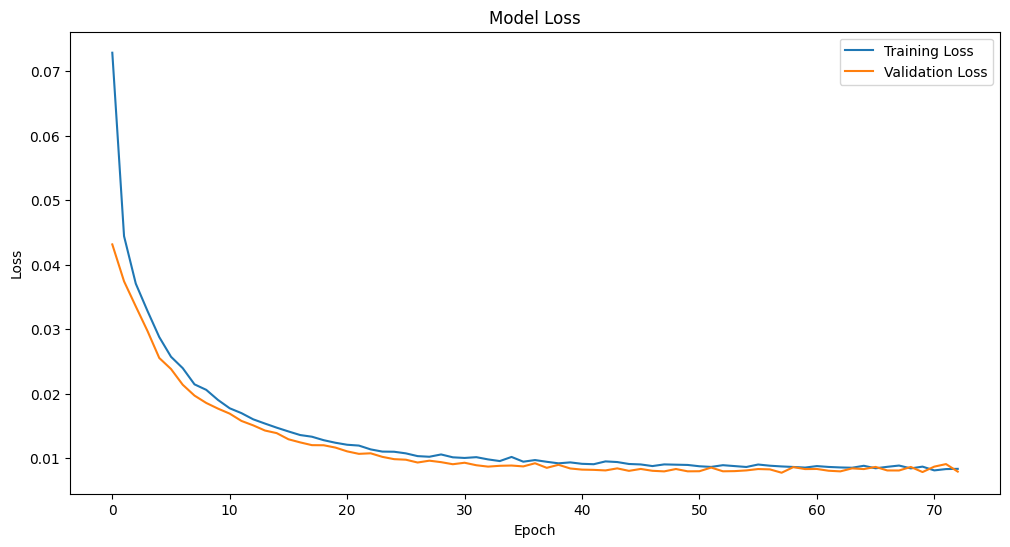

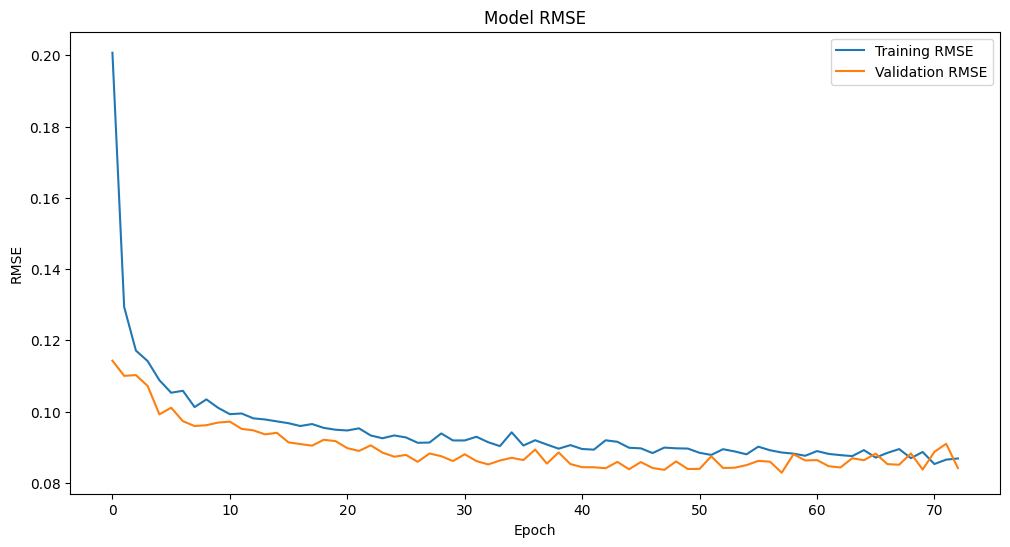

In [40]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

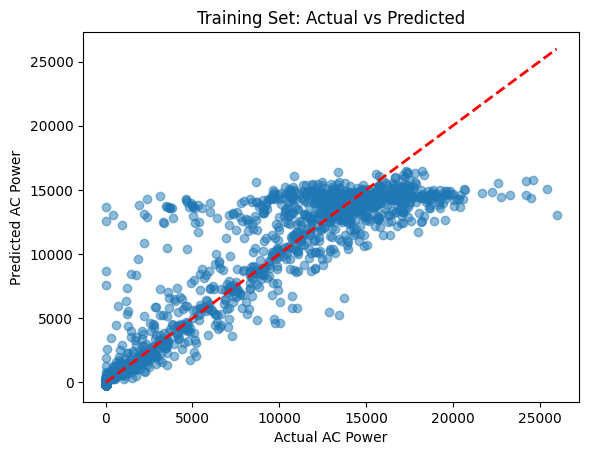

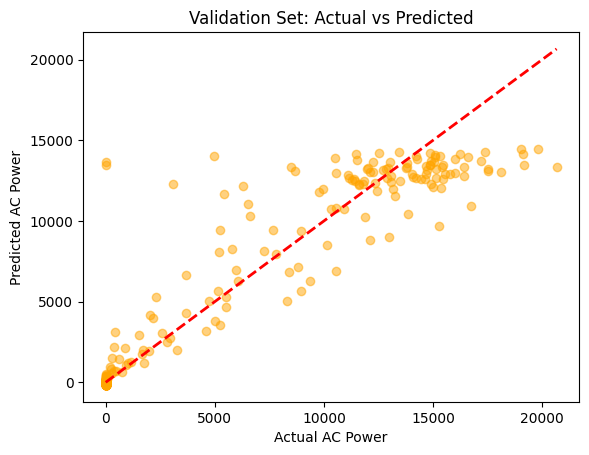

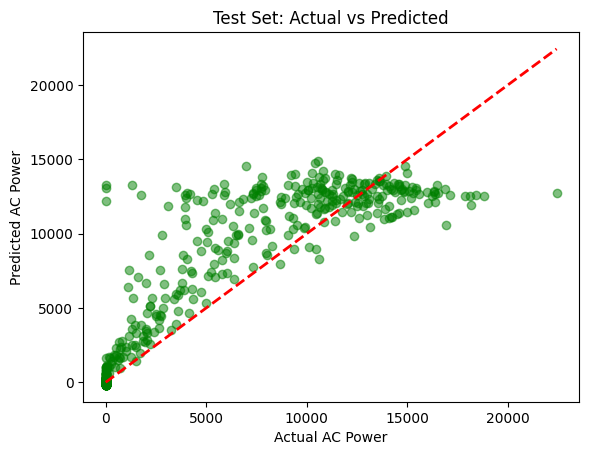

In [41]:
plt.plot(figsize=(12,6))
plt.scatter(train_actual_orig, train_pred_orig, alpha=0.5)
plt.plot([train_actual_orig.min(), train_actual_orig.max()], 
         [train_actual_orig.min(), train_actual_orig.max()], 'r--', lw=2)
plt.xlabel('Actual AC Power')
plt.ylabel('Predicted AC Power')
plt.title('Training Set: Actual vs Predicted')
plt.show()

plt.plot(figsize=(12,6))
plt.scatter(val_actual_orig, val_pred_orig, alpha=0.5, color='orange')
plt.plot([val_actual_orig.min(), val_actual_orig.max()], 
         [val_actual_orig.min(), val_actual_orig.max()], 'r--', lw=2)
plt.xlabel('Actual AC Power')
plt.ylabel('Predicted AC Power')
plt.title('Validation Set: Actual vs Predicted')
plt.show()

plt.plot(figsize=(12,6))
plt.scatter(test_actual_orig, test_pred_orig, alpha=0.5, color='green')
plt.plot([test_actual_orig.min(), test_actual_orig.max()], 
         [test_actual_orig.min(), test_actual_orig.max()], 'r--', lw=2)
plt.xlabel('Actual AC Power')
plt.ylabel('Predicted AC Power')
plt.title('Test Set: Actual vs Predicted')
plt.show()

In [42]:
from tensorflow.keras.models import load_model
model.save("Plant2.1_Model.keras")